In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
train_dataset = torchvision.datasets.FashionMNIST("./data", download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=transforms.ToTensor())

In [3]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

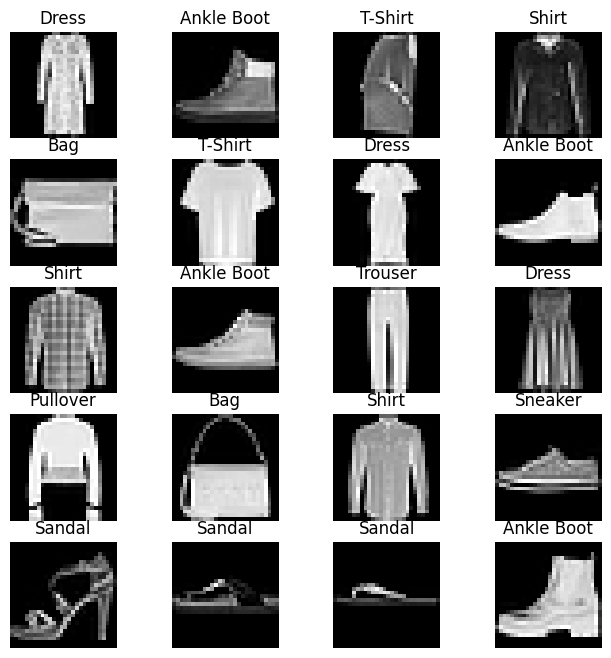

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

labels_map = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5

for i in range(1, columns * rows + 1):
    img_xy = np.random.randint(len(train_dataset))
    label = train_dataset.targets[img_xy]
    img = train_dataset.data[img_xy]  # Convert to numpy and ensure uint8 format
    img = train_dataset.data[img_xy].numpy()

    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[label.item()])  # 레이블 매핑
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [5]:
class FashionDNN(nn.Module):

    def __init__(self):
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        out = x.view(-1, 784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [6]:
learning_rate = 0.001
model = FashionDNN()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [7]:
num_epochs = 5
count = 0
lost_list = []
iteration_list = []
accuracy_list = []

prediction_list = []
labels_list = []

for epoch in range(num_epochs):
    for i in range(0,len(train_dataset),100):
        data = train_dataset.data[i:i+100].type(torch.FloatTensor)
        targets = train_dataset.targets[i:i+100]
        train = Variable(data.view(100, 1, 28, 28))
        labels = Variable(targets)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count = count + 1

        if not (count % 50):
            total = 0
            correct = 0
            for j in range(0, len(train_dataset), 100):
                test_data = train_dataset.data[j:j+100].type(torch.FloatTensor)
                test_targets = train_dataset.targets[j:j+100]
                labels_list.append(test_targets)
                test = Variable(test_data.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1]
                prediction_list.append(predictions)
                correct += (predictions == test_targets).sum()
                total += len(test_targets)

            accuracy = correct * 100 / total
            lost_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print(f'Iteration: {count}, Accuracy: {accuracy}, Loss: {loss.data}')

Iteration: 500, Accuracy: 78.07666778564453, Loss: 0.7777470350265503
Iteration: 1000, Accuracy: 81.36333465576172, Loss: 0.5261390805244446
Iteration: 1500, Accuracy: 81.9366683959961, Loss: 0.5049831867218018
Iteration: 2000, Accuracy: 83.75833129882812, Loss: 0.6292935013771057
Iteration: 2500, Accuracy: 83.2683334350586, Loss: 0.5016036033630371
Iteration: 3000, Accuracy: 83.75666809082031, Loss: 0.34576520323753357


In [8]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc1 = nn.Linear(in_features=6 * 6 * 64, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

In [9]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
learning_rate = 0.001
model = FashionCNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)
print(device)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)
mps


In [13]:
num_epochs = 5
count = 0
lost_list = []
iteration_list = []
accuracy_list = []

prediction_list = []
labels_list = []


for epoch in range(num_epochs):
    for i in range(0,len(train_dataset),100):
        data = train_dataset.data[i:i+100].type(torch.FloatTensor)
        targets = train_dataset.targets[i:i+100]
        data = data.to(device)
        targets = targets.to(device)
        train = Variable(data.view(100, 1, 28, 28))
        labels = Variable(targets)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count = count + 1

        if not (count % 50):
            total = 0
            correct = 0
            for j in range(0, len(train_dataset), 100):
                test_data = train_dataset.data[j:j+100].type(torch.FloatTensor)
                test_targets = train_dataset.targets[j:j+100]
                test_data = test_data.to(device)
                test_targets = test_targets.to(device)
                labels_list.append(test_targets)
                test = Variable(test_data.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1]
                prediction_list.append(predictions)
                correct += (predictions == test_targets).sum()
                total += len(test_targets)

            accuracy = correct * 100 / total
            lost_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print(f'Iteration: {count}, Accuracy: {accuracy}, Loss: {loss.data}')

Iteration: 500, Accuracy: 88.30999755859375, Loss: 0.5484359264373779
Iteration: 1000, Accuracy: 88.91500091552734, Loss: 0.2938718795776367
Iteration: 1500, Accuracy: 90.28666687011719, Loss: 0.3009752631187439
Iteration: 2000, Accuracy: 91.41166687011719, Loss: 0.22528661787509918
Iteration: 2500, Accuracy: 92.32833099365234, Loss: 0.14227671921253204
Iteration: 3000, Accuracy: 92.1683349609375, Loss: 0.21185243129730225
